/Users/julia98/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:426: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/julia98/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[[2822  460]
 [ 399 2986]]
accuracy: 0.8712, precision: 0.8665, recall: 0.8821, F1: 0.8742
roc: 0.8709842955217889
Feature names: ["('OUT&internal&call',)", "('IN&external&0',)", "('IN&internal&call',)", "('IN&internal&suicide',)", "('OUT&internal&create',)", 'Txn_len', 'N_investments', 'N_payments', 'D_index', 'Avg_investment', 'Std_investment', 'Avg_payment', 'Std_payment', 'Investment_times', 'Payment_times', 'Investment_payment_rate', 'Txn_period', 'N_creator', 'N_investor', 'N_other', "('OUT&internal&call', 'OUT&internal&call')", "('IN&external&0', 'IN&external&0')", "('IN&internal&call', 'IN&internal&call')", "('IN&internal&call', 'OUT&internal&call')", "('IN&external&0', 'IN&external&0', 'IN&external&0')", "('OUT&internal&call', 'OUT&internal&call', 'OUT&internal&call')", "('IN&internal&call', 'IN&internal&call', 'IN&internal&call')", "('IN&internal&call', 'IN&internal&call', 'OUT&internal&call')", "('IN&internal&call', 'OUT&internal&call', 'OUT&internal&call')", "('IN&external&

<Figure size 1296x648 with 0 Axes>

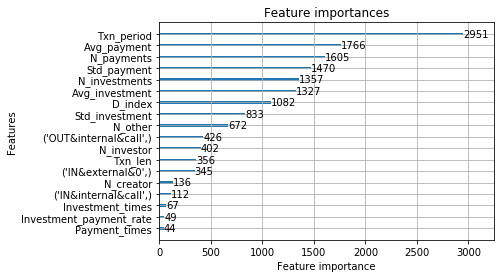

In [2]:
#!/usr/bin/env python
# coding=utf-8

import lightgbm as lgb
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

if __name__ == '__main__':
    basepath = "feature/feature3/"
    generatepath = "res/res3/"
    figpath = "fig/fig3/"
    label = 3    
    method = "ALL" # or TBF or ALL(APF+TBF)
    N = 11 # 11 means 1~10 0 means APF, don't need N-Gram
    
    sf1 = pd.read_csv(basepath + "1gramfeature_short.csv")
    sf2 = pd.read_csv(basepath + "2gramfeature_short.csv")
    sf3 = pd.read_csv(basepath + "3gramfeature_short.csv")
    sf4 = pd.read_csv(basepath + "4gramfeature_short.csv")
    sf5 = pd.read_csv(basepath + "5gramfeature_short.csv")
    sf6 = pd.read_csv(basepath + "6gramfeature_short.csv")
    sf7 = pd.read_csv(basepath + "7gramfeature_short.csv")
    sf8 = pd.read_csv(basepath + "8gramfeature_short.csv")
    sf9 = pd.read_csv(basepath + "9gramfeature_short.csv")
    sf10 = pd.read_csv(basepath + "10gramfeature_short.csv")  
    
    subtrainLabel = pd.read_csv('subtrainLabels' + str(label) + '.csv')
    if(method == "APF"):
        sf = sf1.drop(sf1.columns[1:-15], axis=1)
    elif(method == "TBF"):
        if(N < 11):
            sf = pd.read_csv(basepath + str(N) + "gramfeature_short.csv")
            sf = sf[sf.columns[0:-15]]
        elif(N == 11):
            sf = pd.concat([sf1[sf1.columns[0:-15]],sf2[sf2.columns[1:-15]],sf3[sf3.columns[1:-15]],sf4[sf4.columns[1:-15]],sf5[sf5.columns[1:-15]],sf6[sf6.columns[1:-15]],sf7[sf7.columns[1:-15]],sf8[sf8.columns[1:-15]],sf9[sf9.columns[1:-15]],sf10[sf10.columns[1:-15]]],axis=1)
    elif(method == "ALL"):
        if(N < 11):
            sf = pd.read_csv(basepath + str(N) + "gramfeature_short.csv")
        elif(N == 11):
            sf = pd.concat([sf1,sf2[sf2.columns[1:-15]],sf3[sf3.columns[1:-15]],sf4[sf4.columns[1:-15]],sf5[sf5.columns[1:-15]],sf6[sf6.columns[1:-15]],sf7[sf7.columns[1:-15]],sf8[sf8.columns[1:-15]],sf9[sf9.columns[1:-15]],sf10[sf10.columns[1:-15]]],axis=1)


    df = pd.DataFrame(sf)
    df.to_csv("tmp.csv",index=False)
    subtrain = pd.merge(subtrainLabel, sf, on='Id')
    labels = subtrain.Class
    subtrain.drop(["Class","Id"], axis=1, inplace=True)
    feature = subtrain.columns
#     subtrain = subtrain.values

    k = 1
    n_splits = 5
    _sum = 0
    _sum_recall = 0
    _sum_precision = 0
    _sum_f1 = 0


    X_train, X_test, y_train, y_test = train_test_split(subtrain, labels, test_size=1.0 / 3)

    lgb_train = lgb.Dataset(X_train, y_train) # 将数据保存到LightGBM二进制文件将使加载更快
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)  # 创建验证数据

    param = {'num_leaves':31, 'num_trees':500, 'boosting_type': 'gbdt', 'objective':'binary'}
    param['metric'] = ['auc', 'binary_logloss']
    num_round = 100
    # model = lgb.train(param, lgb_train, num_round, valid_sets=lgb_eval,early_stopping_rounds=10)
    bst=lgb.cv(param,lgb_train, num_round, nfold=5, early_stopping_rounds=30)
    model = lgb.train(param,lgb_train,num_boost_round=len(bst['auc-mean']))

    model.save_model(generatepath + method + str(N) + 'lightGBM_model.txt')
    y_pred1 = model.predict(X_test, num_iteration=model.best_iteration) #如果在训练期间启用了早期停止，可以通过best_iteration方式从最佳迭代中获得预测
    # y_pred = model.predict(X_test)
    y_pred = (y_pred1 >= 0.5)*1
    _matrix = confusion_matrix(y_test, y_pred)
    print(_matrix)
    acc = accuracy_score(y_test,y_pred)
    precision, recall, F1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")
    print ("accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f}, F1: {3:.4f}".format(acc, precision, recall, F1))
    print('roc:', roc_auc_score(y_test, y_pred) )
    print('Feature names:', list(feature))
    print('Feature importances:', list(model.feature_importance()))
    res = {'acc':[acc], 'precision':[precision], 'recall':[recall],'f1-score':[F1]}
    df = pd.DataFrame(res)
    df.to_csv(generatepath + method + str(N) + "LightGBM.csv",index=False)    
    
    plt.figure(figsize=(18,9))
    lgb.plot_importance(model, max_num_features=30)
    plt.title("Feature importances")
    plt.savefig(figpath + method + str(N) + "LightGBM.png")
    plt.show()

    feature_importance = pd.DataFrame({'feature_name':list(feature),'importance':list(model.feature_importance())} )
    feature_importance.to_csv(figpath + method + str(N) + 'LightGBM feature_importance.csv',index=False)

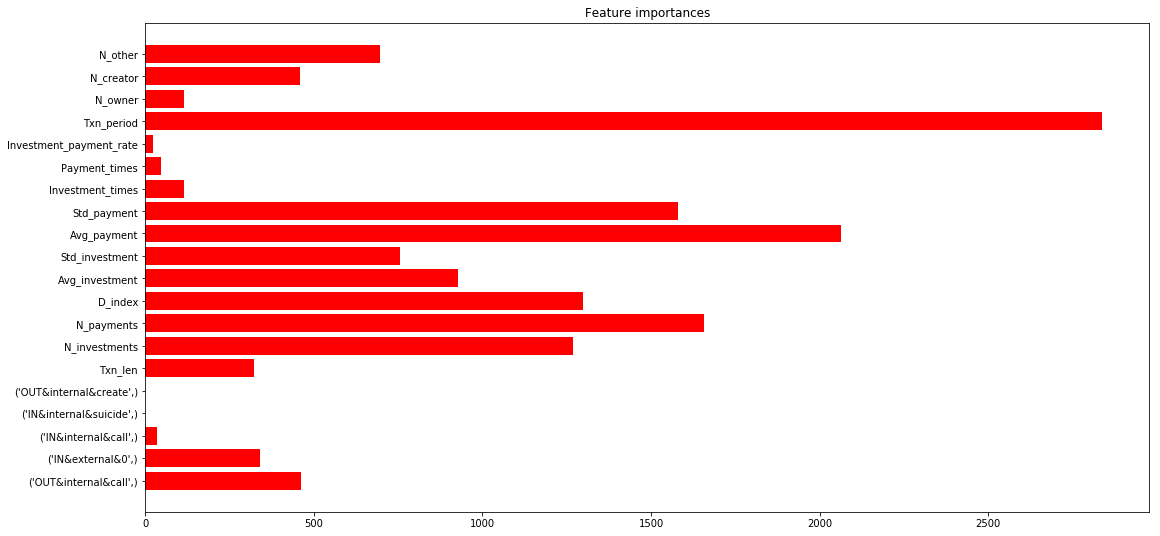

In [3]:
import matplotlib.pyplot as plt
names = ["('OUT&internal&call',)", "('IN&external&0',)", "('IN&internal&call',)", "('IN&internal&suicide',)", "('OUT&internal&create',)", 'Txn_len', 'N_investments', 'N_payments', 'D_index', 'Avg_investment', 'Std_investment', 'Avg_payment', 'Std_payment', 'Investment_times', 'Payment_times', 'Investment_payment_rate', 'Txn_period', 'N_owner', 'N_creator', 'N_other']
importances = [463, 340, 34, 0, 0, 323, 1270, 1656, 1298, 927, 755, 2064, 1580, 116, 46, 24, 2836, 114, 458, 696]
plt.figure(figsize=(18,9))
plt.title("Feature importances")
n=20
plt.barh(range(n), importances[:n], color="r", tick_label=names[:n])
# plt.xticks(range(n), indices)
# plt.xlim([-1, n])
plt.show()
plt.savefig("fig/ALL11")

In [51]:
sf1 = pd.read_csv("feature/feature3/1gramfeature_short.csv")
# sf = sf1[sf1.columns[0:1]] + sf1[sf1.columns[-15:]]
sf = sf1.drop(sf1.columns[1:-15], axis=1)
sf

,Id,Txn_len,N_investments,N_payments,D_index,Avg_investment,Std_investment,Avg_payment,Std_payment,Investment_times,Payment_times,Investment_payment_rate,Txn_period,N_owner,N_creator,N_other
0,66a862159eaf0131e1a8f740630a31ea4f3a&0xa3c1e32...,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0,1,0.0,0,0,0,1
1,71d978d942e072d09ae75a86525278f496e3&0x8d12a19...,2,0.000000,0.074563,-0.074563,0.000000,0.000000,0.037282,3.702910e-03,0,2,0.0,376,0,0,2
2,529cb8c48a2ca7d7cf52c634e87dcdba21ce&0xa3c1e32...,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0,1,0.0,0,0,0,1
3,8ce64c06e3e0869c8f97b268de2cf72283d0&0x67a5de9...,3,0.000000,0.000587,-0.000587,0.000000,0.000000,0.000196,4.499713e-05,0,3,0.0,187456,0,2,1
4,027a4ccd46ec98199fa88aaedf5aa981db26&0x41a21b2...,15,4.500000,0.000000,4.500000,0.300000,1.161895,0.000000,0.000000e+00,15,0,16.0,264630,0,0,0
5,c244d798123fde783fcc1c72d3bb8c189413&0x2692680...,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1,0,2.0,0,0,0,0
6,fb5a3871b500f65bdfafe0136f9667deae06&0x119d0ce...,1,0.064600,0.000000,0.064600,0.064600,0.000000,0.000000,0.000000e+00,1,0,2.0,0,0,0,0
7,a94016313d44eb9fc6deb0f46b69930b8b55&0xb281622...,27,0.000000,18.427213,-18.427213,0.000000,0.000000,0.682489,4.496767e-01,0,27,0.0,2531853,0,0,27
8,ca498f7271b579eec4061222ea44b5cbd59d&0xe1c9a03...,32,0.000000,0.231737,-0.231737,0.000000,0.000000,0.007242,1.120095e-02,0,32,0.0,18059991,0,0,32
9,c12ec0f81966cbceb1241272082357d30e10&0x2f6321d...,1,0.000000,0.000588,-0.000588,0.000000,0.000000,0.000588,0.000000e+00,0,1,0.0,0,0,0,1
